In [5]:
from cif import cif
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [6]:
database = cif.createOneCountryDataFrameFromOECD('USA', 'MEI', 
                                     frequency='Q', startDate='1990-Q1')
usa_df = database[0]
labelvar = database[1]

Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions


In [7]:
usa_df

subject B6BLPI01                            B6BLSE01                    \
measure     CXCU   CXCUSA     NCCU   NCCUSA     CXCU   CXCUSA     NCCU   
time                                                                     
1990-Q1   6667.0   5928.0   6667.0   5928.0   8101.0   6843.0   8101.0   
1990-Q2   6120.0   6406.0   6120.0   6406.0   5695.0   7224.0   5695.0   
1990-Q3   3862.0   5227.0   3862.0   5227.0   6986.0   7479.0   6986.0   
1990-Q4  11900.0  10988.0  11900.0  10988.0   9391.0   8633.0   9391.0   
1991-Q1   8663.0   8108.0   8663.0   8108.0   9362.0   8090.0   9362.0   
...          ...      ...      ...      ...      ...      ...      ...   
2019-Q3  61172.0  61621.0  61172.0  61621.0  70601.0  71471.0  70601.0   
2019-Q4  61787.0  61958.0  61787.0  61958.0  82290.0  72738.0  82290.0   
2020-Q1  52895.0  52036.0  52895.0  52036.0  61737.0  65272.0  61737.0   
2020-Q2  29307.0  29213.0  29307.0  29213.0  53318.0  54440.0  53318.0   
2020-Q3      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

subject          B6BLSI01           ...   XTIMVA01                       \
measure   NCCUSA     CXCU   CXCUSA  ...       GPSA       GYSA      NCML   
time                                ...                                   
1990-Q1   6843.0  -6643.0  -6540.0  ...   2.188316   5.678085  119.7550   
1990-Q2   7224.0  -7331.0  -7644.0  ...  -1.055037   1.448198  120.9364   
1990-Q3   7479.0  -7213.0  -7339.0  ...   2.784438   5.201709  124.3284   
1990-Q4   8633.0  -5467.0  -5133.0  ...   1.986900   5.990437  130.2908   
1991-Q1   8090.0  14721.0  14828.0  ...  -5.780600  -2.274978  115.9279   
...          ...      ...      ...  ...        ...        ...       ...   
2019-Q3  71471.0 -33794.0 -33556.0  ...  -0.554719  -2.219772  641.1710   
2019-Q4  72738.0 -36952.0 -36524.0  ...  -2.797840  -5.398035  621.1790   
2020-Q1  65272.0 -36864.0 -37075.0  ...  -3.037014  -6.230327  569.0640   
2020-Q2  54440.0 -34513.0 -34856.0  ... -14.468203 -19.833362  509.0920   
2020-Q3      NaN      NaN      NaN  ...  18.501470  -4.471440  610.6930   

subject                       XTNTVA01                                          
measure    NCMLSA       STSA      CXML    CXMLSA      NCML    NCMLSA      STSA  
time                                                                            
1990-Q1  122.3748   8.335163  -22.1585  -25.8646  -22.1585  -25.8646 -1.761683  
1990-Q2  121.0837   8.126385  -20.3104  -22.8322  -20.3104  -22.8322 -1.532355  
1990-Q3  124.4552   8.276163  -30.4250  -27.2787  -30.4250  -27.2787 -1.814010  
1990-Q4  126.9280   8.455197  -28.8245  -25.0540  -28.8245  -25.0540 -1.668950  
1991-Q1  119.5908   7.926248  -13.1684  -17.2519  -13.1684  -17.2519 -1.143423  
...           ...        ...       ...       ...       ...       ...       ...  
2019-Q3  627.0910  11.644968 -235.5700 -218.4390 -235.5700 -218.4390 -4.056373  
2019-Q4  609.5460  11.211385 -206.5630 -200.2780 -206.5630 -200.2780 -3.683715  
2020-Q1  591.0340  10.964801 -173.3290 -189.3410 -173.3290 -189.3410 -3.512634  
2020-Q2  505.5220  10.358997 -217.6880 -217.0510 -217.6880 -217.0510 -4.447740  
2020-Q3  599.0510  11.325756 -258.3530 -242.4530 -258.3530 -242.4530 -4.583856  

[123 rows x 792 columns]

In [8]:
##--- Création d'un dataframe pour USA ----

liste_var = ['NAEXKP01', 'LREMTTTT', 'LRACTTTT', 'LRUNTTTT', 
             'NAEXKP02', 'NAEXKP04', 'NAEXKP06']

headers = ['PIB', 'Emplois', 'Actifs', 'Chomage', 'Conso', 
           'Formation', 'Exports']

d = {col:var_df for col, var_df in zip(headers, [usa_df['{0}'.format(var)]["STSA"] for var in liste_var] )}
usa_bon_df = pd.DataFrame(d)

In [9]:
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports
time,,,,,,,
1990-Q1,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300
1990-Q2,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785
1990-Q3,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014
1990-Q4,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143
1991-Q1,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434
...,...,...,...,...,...,...,...
2019-Q3,19141.744,60.866667,63.133333,3.633333,13301.349,4054.506,2536.562
2019-Q4,19253.959,61.000000,63.233333,3.533333,13353.687,4075.404,2557.846
2020-Q1,19010.848,60.766667,63.166667,3.833333,13118.406,4075.494,2495.099


In [10]:
## Créons d'abord une colonne time qui donne la date sous le format AAAA-MM-JJ

qs = usa_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
usa_bon_df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
usa_bon_df = usa_bon_df.reindex(index=usa_bon_df['date'])
usa_bon_df = usa_bon_df.drop("date", axis=1)
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports
date,,,,,,,
1990-01-01,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300
1990-04-01,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785
1990-07-01,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014
1990-10-01,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143
1991-01-01,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434
...,...,...,...,...,...,...,...
2019-07-01,19141.744,60.866667,63.133333,3.633333,13301.349,4054.506,2536.562
2019-10-01,19253.959,61.000000,63.233333,3.533333,13353.687,4075.404,2557.846
2020-01-01,19010.848,60.766667,63.166667,3.833333,13118.406,4075.494,2495.099


Text(0.5, 1.0, 'Évolution du PIB américain depuis 1990')

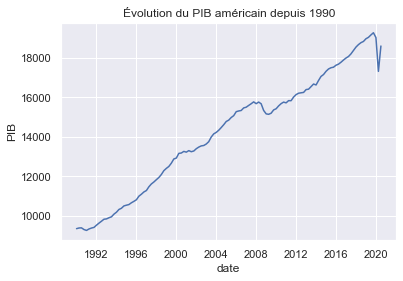

In [11]:
## ------ Stat Des -------------

sns.set_theme(style="darkgrid")

PIB_graph = sns.lineplot(data=usa_bon_df, x= 'date', y='PIB')
PIB_graph.set_title("Évolution du PIB américain depuis 1990")

In [12]:
#Préparation pour test stationnaire
PIB_temp = usa_bon_df['PIB']

In [13]:
# SARIMAX
mdl = sm.tsa.statespace.SARIMAX(PIB_temp,order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


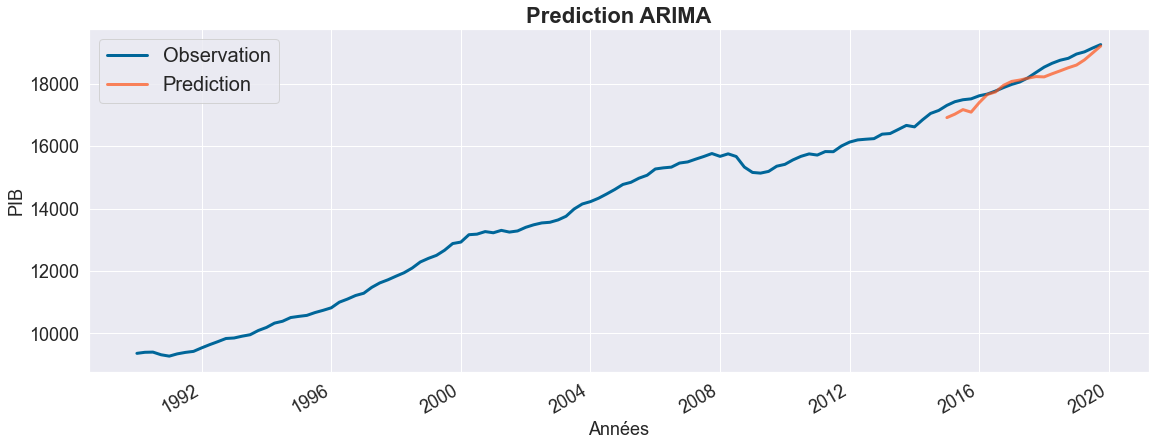

<ipython-input-14-d3cb16f8586c>:26: RuntimeWarning: Mean of empty slice.
  rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - PIB_temp[200:].values) ** 2).mean())
C:\Users\Asus\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(PIB_temp,
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

# in-sample-prediction and confidence bounds
pred = res.get_prediction(start = "2015-01-01", 
                          end = "2019-10-01",
                          dynamic = False, 
                          full_results=True)


 # plot in-sample-prediction
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(PIB_temp[0:120],color='#006699',linewidth = 3, label='Observation');
pred.predicted_mean.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.set_xlabel('Années', fontsize=18)
ax.set_ylabel('PIB', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction ARIMA', fontsize=22, fontweight="bold")
plt.show()

rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - PIB_temp[200:].values) ** 2).mean())

In [15]:
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                       PIB   No. Observations:                  123
Model:             SARIMAX(2, 2, [1], 7)   Log Likelihood                -815.285
Date:                   Fri, 11 Dec 2020   AIC                           1638.570
Time:                           15:48:07   BIC                           1649.335
Sample:                       01-01-1990   HQIC                          1642.935
                            - 07-01-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1888      0.204      0.927      0.354      -0.210       0.588
ar.S.L14      -0.0895      0.155     -0.578      0.563      -0.393       0.214
ma.S.L7       -0.7904      0